CNN

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os

:)


In [10]:
output_path = "mfcc_data"
os.makedirs(output_path, exist_ok=True)

def extract_mfcc(file_path, n_mfcc=40, max_len=216):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Normalize length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

:)


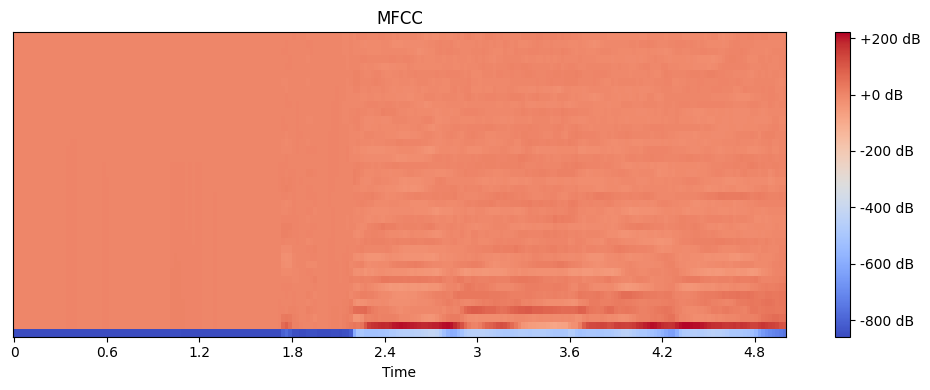

In [14]:
import librosa.display
import matplotlib.pyplot as plt

# Assuming `mfcc` is a 2D NumPy array (shape: [n_mfcc, time_frames])
plt.figure(figsize=(10, 4))
librosa.display.specshow(extract_mfcc("03-01-07-01-02-02-01.wav"), x_axis='time')
plt.colorbar(format="%+2.0f dB")
plt.title("MFCC")
plt.tight_layout()
plt.show()


In [21]:
import whisper

model = whisper.load_model("base")  # or "small", "medium", "large"

result = model.transcribe("03-01-07-01-02-02-01.wav")
print("Transcription:", result["text"])

/root/miniconda3/envs/emotion_env/lib/python3.10/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription:  Dogs are sitting by the door.


In [18]:
pip install -U openai-whisper

  Using cached openai-whisper-20240930.tar.gz (800 kB)
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 299.9 kB/s eta 0:00:00 kB/s eta 0:00:01:02
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803404 sha256=c1afae0832265cd72746baa09a84880d7035533fc9fa031bc84978004e1f3cfa
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [openai-whisper]━━━ 2/3 [openai-whisper]
Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import librosa
import numpy as np

# Set paths
dataset_path = "voice_dataset"
output_path = "mfcc_data"
os.makedirs(output_path, exist_ok=True)

def extract_mfcc(file_path, n_mfcc=40, max_len=216):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to fixed length for uniform input
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc
i=0
# Traverse all actors and wav files
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            try:
                file_path = os.path.join(root, file)
                mfcc = extract_mfcc(file_path)
                label = file.split("-")[2]  # Emotion label
                save_name = file.replace(".wav", ".npy")
                # print(i+1);
                # i+=1;
                np.save(os.path.join(output_path, save_name), mfcc)
            except Exception as e:
                print(f"Skipping {file} due to error: {e}")
print("done")

done


In [25]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class MFCCDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        mfcc = np.load(self.file_paths[idx])  # (n_mfcc, time)
        mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # (1, n_mfcc, time)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return mfcc, label

# Load file paths & labels
data_dir = "mfcc_data"
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]
labels = [int(os.path.basename(f).split("-")[2]) - 1 for f in file_paths]  # 0-indexed emotions

# Train/val split
train_files, val_files, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# DataLoaders
batch_size = 32
train_dataset = MFCCDataset(train_files, train_labels)
val_dataset = MFCCDataset(val_files, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [28]:
class CNNEmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout(0.3)

        # Placeholder for dynamically determining flatten size
        self.flattened_size = None

        # Define dummy input to infer size
        self._init_linear_layer()

    def _init_linear_layer(self):
        # Dummy forward to calculate size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 40, 216)  # typical MFCC shape
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNEmotionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    train_loss, correct = 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == targets).sum().item()

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


Epoch 1, Loss: 8942.6067, Train Acc: 0.1337
Epoch 2, Loss: 2229.1072, Train Acc: 0.2752
Epoch 3, Loss: 1915.7588, Train Acc: 0.3941
Epoch 4, Loss: 1614.9838, Train Acc: 0.5017
Epoch 5, Loss: 1327.6346, Train Acc: 0.5972
Epoch 6, Loss: 1143.4154, Train Acc: 0.6571
Epoch 7, Loss: 825.3029, Train Acc: 0.7500
Epoch 8, Loss: 542.3569, Train Acc: 0.8472
Epoch 9, Loss: 291.0340, Train Acc: 0.9314
Epoch 10, Loss: 147.7643, Train Acc: 0.9714
Epoch 11, Loss: 131.2673, Train Acc: 0.9757
Epoch 12, Loss: 99.2888, Train Acc: 0.9757
Epoch 13, Loss: 57.3548, Train Acc: 0.9887
Epoch 14, Loss: 68.2726, Train Acc: 0.9826
Epoch 15, Loss: 62.9579, Train Acc: 0.9878
Epoch 16, Loss: 34.6086, Train Acc: 0.9931
Epoch 17, Loss: 37.1944, Train Acc: 0.9939
Epoch 18, Loss: 39.1976, Train Acc: 0.9931
Epoch 19, Loss: 20.2960, Train Acc: 0.9965
Epoch 20, Loss: 22.7353, Train Acc: 0.9948
Epoch 21, Loss: 25.7730, Train Acc: 0.9939
Epoch 22, Loss: 45.5116, Train Acc: 0.9870
Epoch 23, Loss: 45.7161, Train Acc: 0.9878
Epo

In [31]:
model.eval()
correct = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        correct += (outputs.argmax(1) == targets).sum().item()

val_acc = correct / len(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.4167


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNNEmotionModel(nn.Module):
    def __init__(self):
        super(DeepCNNEmotionModel, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        # Compute the flattened feature size after 3 poolings
        # Starting from (1, 40, 216) → (128, 5, 27)
        self.fc1 = nn.Linear(128 * 5 * 27, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 8)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNEmotionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    train_loss, correct = 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == targets).sum().item()

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


Epoch 1, Loss: 8834.0464, Train Acc: 0.1380
Epoch 2, Loss: 2395.4630, Train Acc: 0.1372
Epoch 3, Loss: 2277.7856, Train Acc: 0.2092
Epoch 4, Loss: 1845.8404, Train Acc: 0.4158
Epoch 5, Loss: 1379.1804, Train Acc: 0.5720
Epoch 6, Loss: 1003.8470, Train Acc: 0.7023
Epoch 7, Loss: 697.6840, Train Acc: 0.8021
Epoch 8, Loss: 416.7323, Train Acc: 0.8845
Epoch 9, Loss: 272.7730, Train Acc: 0.9314
Epoch 10, Loss: 177.8911, Train Acc: 0.9575
Epoch 11, Loss: 138.2193, Train Acc: 0.9722
Epoch 12, Loss: 91.5216, Train Acc: 0.9809
Epoch 13, Loss: 52.7259, Train Acc: 0.9922
Epoch 14, Loss: 42.9813, Train Acc: 0.9939
Epoch 15, Loss: 28.3471, Train Acc: 0.9983
Epoch 16, Loss: 51.8334, Train Acc: 0.9861
Epoch 17, Loss: 65.9471, Train Acc: 0.9922
Epoch 18, Loss: 29.2266, Train Acc: 0.9965
Epoch 19, Loss: 23.2028, Train Acc: 0.9948
Epoch 20, Loss: 26.2233, Train Acc: 0.9939
Epoch 21, Loss: 24.2076, Train Acc: 0.9957
Epoch 22, Loss: 24.7418, Train Acc: 0.9922
Epoch 23, Loss: 28.1271, Train Acc: 0.9939
Epo

In [34]:
model.eval()
correct = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        correct += (outputs.argmax(1) == targets).sum().item()

val_acc = correct / len(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.3785


In [ ]:
import whisper
import os
from pathlib import Path

# Load Whisper model
model = whisper.load_model("base")

# Define synthetic sentences
emotion_map = {
    "01": "I am speaking in a neutral tone.",
    "02": "I am calm and composed.",
    "03": "I feel very happy today!",
    "04": "I feel so down today.",
    "05": "I am furious right now!",
    "06": "I am really scared.",
    "07": "This is so disgusting!",
    "08": "I can't believe this happened!"
}

# Extract emotion ID from filename
def extract_emotion_id(filename):
    try:
        parts = filename.split("-")
        return parts[2]
    except Exception:
        return None

# Directory setup
root_dir = "voice_dataset"
output_file = "transcripts_with_emotion.txt"
with open(output_file, "w", encoding="utf-8") as out_f:
    for actor_dir in os.listdir(root_dir):
        actor_path = os.path.join(root_dir, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith(".wav") and not file.endswith(".wav:Zone.Identifier"):
                    file_path = os.path.join(actor_path, file)
                    try:
                        result = model.transcribe(file_path)
                        transcript = result["text"].strip()
                        
                        # Use synthetic sentence if transcript is too short
                        if len(transcript.split()) < 3:
                            emotion_id = extract_emotion_id(file)
                            transcript = emotion_map.get(emotion_id, "[UNKNOWN EMOTION]")
                            print(f" → Replaced with synthetic: {transcript}")
                        
                        out_f.write(f"{file_path}\t{transcript}\n")
                    except Exception as e:
                        print(f"Error with {file_path}: {e}")


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import re

# Read and parse dataset
def load_data(file_path):
    texts = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            path, *transcript = line.strip().split()
            text = ' '.join(transcript)
            emotion_id = int(path.split('/')[-1].split('-')[2])
            # Map 1-8 to 0-7
            label = emotion_id - 1
            texts.append(text.lower())
            labels.append(label)
    return texts, labels

# Simple tokenizer and vocabulary builder
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(tokenize(text))
    vocab = {word: i + 2 for i, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab

def encode(text, vocab, max_len=20):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab['<unk>']) for token in tokens[:max_len]]
    return ids + [vocab['<pad>']] * (max_len - len(ids))

# Dataset class
class EmotionTextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=20):
        self.data = [encode(text, vocab, max_len) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

# GRU Model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        return self.fc(hidden.squeeze(0))

# Training loop
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [28]:
# Main script
texts, labels = load_data('transcripts_with_emotion.txt')
vocab = build_vocab(texts, min_freq=1)

X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_dataset = EmotionTextDataset(X_train, y_train, vocab)
val_dataset = EmotionTextDataset(X_val, y_val, vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUClassifier(vocab_size=len(vocab), embed_dim=64, hidden_dim=128, output_dim=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
for epoch in range(10):
    loss = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Epoch 1, Loss: 2.0689
Epoch 2, Loss: 2.0637
Epoch 3, Loss: 2.0623
Epoch 4, Loss: 2.0624
Epoch 5, Loss: 2.0611
Epoch 6, Loss: 2.0617
Epoch 7, Loss: 2.0620
Epoch 8, Loss: 2.0617
Epoch 9, Loss: 2.0621
Epoch 10, Loss: 2.0613


In [31]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, val_dataset, device):
    model.eval()
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc * 100:.2f}%\n")

In [32]:
evaluate_model(model, val_dataset, device)

Validation Accuracy: 10.07%

